# Incidence of influenza-like illness in France

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os.path
from os import path

The data on the incidence of influenza-like illness are available from the Web site of the [Réseau Sentinelles](http://www.sentiweb.fr/). We download them as a file in CSV format, in which each line corresponds to a week in the observation period. Only the complete dataset, starting in 1984 and ending with a recent week, is available for download.

In [16]:
# Old Version
# data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-3.csv"

# New Version
if not path.exists("data.csv"):
    !wget http://www.sentiweb.fr/datasets/incidence-PAY-3.csv -O data.csv

This is the documentation of the data from [the download site](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Column name  | Description                                                                                                               |
|--------------|---------------------------------------------------------------------------------------------------------------------------|
| `week`       | ISO8601 Yearweek number as numeric (year times 100 + week nubmer)                                                               |
| `indicator`  | Unique identifier of the indicator, see metadata document https://www.sentiweb.fr/meta.json                               |
| `inc`        | Estimated incidence value for the time step, in the geographic level                                                      |
| `inc_low`    | Lower bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc_up`     | Upper bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc100`     | Estimated rate incidence per 100,000 inhabitants                                                                          |
| `inc100_low` | Lower bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc100_up`  | Upper bound of the estimated rate incidence 95% Confidence Interval                                                       |
| `geo_insee`  | Identifier of the geographic area, from INSEE https://www.insee.fr                                                        |
| `geo_name`   | Geographic label of the area, corresponding to INSEE code. This label is not an id and is only provided for human reading |

The first line of the CSV file is a comment, which we ignore with `skip=1`.

In [3]:
# Old Version
# raw_data = pd.read_csv(data_url, encoding = 'iso-8859-1', skiprows=1)

# New Version
raw_data = pd.read_csv("data.csv", encoding = 'iso-8859-1', skiprows=1)
raw_data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,202242,3,51989,43580.0,60398.0,78,65.0,91.0,FR,France
1,202241,3,49029,42759.0,55299.0,74,65.0,83.0,FR,France
2,202240,3,41927,36115.0,47739.0,63,54.0,72.0,FR,France
3,202239,3,39902,34168.0,45636.0,60,51.0,69.0,FR,France
4,202238,3,28781,23733.0,33829.0,43,35.0,51.0,FR,France
...,...,...,...,...,...,...,...,...,...,...
1977,198448,3,78620,60634.0,96606.0,143,110.0,176.0,FR,France
1978,198447,3,72029,54274.0,89784.0,131,99.0,163.0,FR,France
1979,198446,3,87330,67686.0,106974.0,159,123.0,195.0,FR,France
1980,198445,3,135223,101414.0,169032.0,246,184.0,308.0,FR,France


Are there missing data points? Yes, week 19 of year 1989 does not have any observed values.

In [4]:
raw_data[raw_data.isnull().any(axis=1)]

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
1745,198919,3,0,NaN,NaN,0,NaN,NaN,FR,France


We delete this point, which does not have big consequence for our rather simple analysis.

In [5]:
data = raw_data.dropna().copy()
data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,202242,3,51989,43580.0,60398.0,78,65.0,91.0,FR,France
1,202241,3,49029,42759.0,55299.0,74,65.0,83.0,FR,France
2,202240,3,41927,36115.0,47739.0,63,54.0,72.0,FR,France
3,202239,3,39902,34168.0,45636.0,60,51.0,69.0,FR,France
4,202238,3,28781,23733.0,33829.0,43,35.0,51.0,FR,France
...,...,...,...,...,...,...,...,...,...,...
1977,198448,3,78620,60634.0,96606.0,143,110.0,176.0,FR,France
1978,198447,3,72029,54274.0,89784.0,131,99.0,163.0,FR,France
1979,198446,3,87330,67686.0,106974.0,159,123.0,195.0,FR,France
1980,198445,3,135223,101414.0,169032.0,246,184.0,308.0,FR,France


Our dataset uses an uncommon encoding; the week number is attached
to the year number, leaving the impression of a six-digit integer.
That is how Pandas interprets it.

A second problem is that Pandas does not know about week numbers.
It needs to be given the dates of the beginning and end of the week.
We use the library `isoweek` for that.

Since the conversion is a bit lengthy, we write a small Python 
function for doing it. Then we apply it to all points in our dataset. 
The results go into a new column 'period'.

In [6]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

There are two more small changes to make.

First, we define the observation periods as the new index of
our dataset. That turns it into a time series, which will be
convenient later on.

Second, we sort the points chronologically.

In [7]:
sorted_data = data.set_index('period').sort_index()

We check the consistency of the data. Between the end of a period and
the beginning of the next one, the difference should be zero, or very small.
We tolerate an error of one second.

This is OK except for one pair of consecutive periods between which
a whole week is missing.

We recognize the dates: it's the week without observations that we
have deleted earlier!

In [8]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

1989-05-01/1989-05-07 1989-05-15/1989-05-21


A first look at the data!

<AxesSubplot: xlabel='period'>

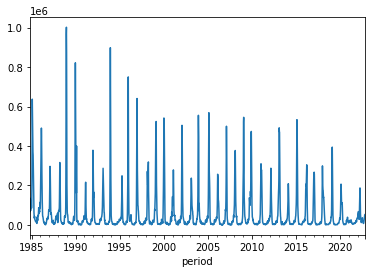

In [9]:
sorted_data['inc'].plot()

A zoom on the last few years shows more clearly that the peaks are situated in winter.

<AxesSubplot: xlabel='period'>

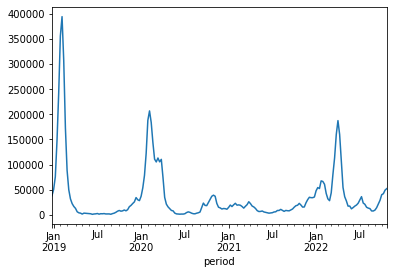

In [10]:
sorted_data['inc'][-200:].plot()

## Study of the annual incidence

Since the peaks of the epidemic happen in winter, near the transition
between calendar years, we define the reference period for the annual
incidence from August 1st of year $N$ to August 1st of year $N+1$. We
label this period as year $N+1$ because the peak is always located in
year $N+1$. The very low incidence in summer ensures that the arbitrariness
of the choice of reference period has no impact on our conclusions.

Our task is a bit complicated by the fact that a year does not have an
integer number of weeks. Therefore we modify our reference period a bit:
instead of August 1st, we use the first day of the week containing August 1st.

A final detail: the dataset starts in October 1984, the first peak is thus
incomplete, We start the analysis with the first full peak.

In [11]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1985,
                                    sorted_data.index[-1].year)]

Starting from this list of weeks that contain August 1st, we obtain intervals of approximately one year as the periods between two adjacent weeks in this list. We compute the sums of weekly incidences for all these periods.

We also check that our periods contain between 51 and 52 weeks, as a safeguard against potential mistakes in our code.

In [12]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

And here are the annual incidences.

<AxesSubplot: >

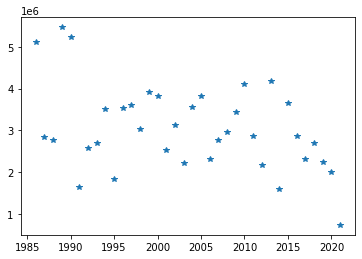

In [13]:
yearly_incidence.plot(style='*')

A sorted list makes it easier to find the highest values (at the end).

In [14]:
yearly_incidence.sort_values()

2021     743449
2014    1600941
1991    1659249
1995    1840410
2020    2010315
2012    2175217
2003    2234584
2019    2254386
2006    2307352
2017    2321583
2001    2529279
1992    2574578
1993    2703886
2018    2705325
1988    2765617
2007    2780164
1987    2855570
2016    2856393
2011    2857040
2008    2973918
1998    3034904
2002    3125418
2009    3444020
1994    3514763
1996    3539413
2004    3567744
1997    3620066
2015    3654892
2000    3826372
2005    3835025
1999    3908112
2010    4111392
2013    4182691
1986    5115251
1990    5235827
1989    5466192
dtype: int64

Finally, a histogram clearly shows the few very strong epidemics, which affect about 10% of the French population,
but are rare: there were three of them in the course of 35 years. The typical epidemic affects only half as many people.

<AxesSubplot: >

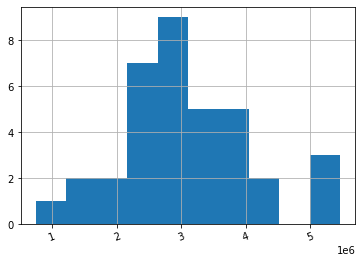

In [15]:
yearly_incidence.hist(xrot=20)